# Executive Summary

This project explores long-term retail trends in the UK using data from the **Office for National Statistics (ONS)** covering the period **1988 to 2025**.  
The goal was to understand how total retail and online sales have evolved over time, what factors drive these changes, and what the future might look like.  

After cleaning and analyzing the data, I found that:
- **Online shopping has become the main growth engine** of UK retail since 2010.  
- **Total retail sales** continue to grow steadily, with visible dips during major events like the 2008 crisis and 2020 pandemic.  
- Seasonal peaks appear **every November and December**, confirming strong holiday-driven sales behavior.  

Using the **Prophet model**, I forecasted both total and online retail sales for the next two years.  
The results show that the retail market is expected to keep growing steadily, with online channels playing an even larger role.  

Overall, this project demonstrates my ability to:
- Work with real-world economic data,  
- Perform exploratory and predictive analysis,  
- And turn findings into practical business insights and recommendations for retail decision-making.

## Introduction

The UK retail sector has undergone significant transformation over the last four decades — from traditional brick-and-mortar stores in the 1980s to the e-commerce boom that accelerated after 2010.
This project analyzes long-term UK retail sales data using official statistics from the Office for National Statistics (ONS) to uncover key trends and generate reliable forecasts.

The goal is to:

•	Understand how total retail and online retail have evolved over time.
    
•	Forecast sales for the next two years using Facebook Prophet.
    
•	Provide clear, data-driven business insights and recommendations.


## 📂 Dataset Source

The dataset used in this project comes from the **UK Office for National Statistics (ONS)** — *Retail Sales Index: Value and Volume Seasonally Adjusted*.  
You can download the latest version directly from the official ONS website below:

🔗 [**Download ONS Retail Sales Index (Main Reference Tables)**](https://www.ons.gov.uk/businessindustryandtrade/retailindustry/datasets/retailsalesindexreferencetables/current)

• Time Frame: January 1988 – August 2025 (456 unique monthly periods, 909 rows).

• Metrics: Retail All, Food, Non-Food, Fuel, and Online Retail indices.

• Frequency: Monthly data.

• Cleaning Steps: • Converted “period” column to datetime format.

• Removed note rows and empty cells.

• Clipped negative/zero values (required for Prophet).

• Ensured continuous monthly sequence with no structural gaps.

Validation:
The data is fully up to date, ending August 2025, and consistent with ONS’ current release. Minor missing values exist only before 1997 (online data not yet recorded), which is expected and does not affect modern trend analysis.

> 📅 *This dataset is updated monthly by ONS. The data in this project includes records from January 1988 to August 2025.*

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import ttest_ind
from prophet import Prophet  
from prophet.diagnostics import performance_metrics, cross_validation
from sklearn.metrics import mean_absolute_error, mean_squared_error
import datetime as dt
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_percentage_error

/opt/anaconda3/envs/clean_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:

# Load total retail sales
df_retail_sales = pd.read_excel("mainreferencetables.xlsx", sheet_name="Table 2 M",header=4)


df_retail_sales.head()

,"The monthly period consists of 4 weeks except for March, June, September and December which are 5 weeks. January 2025 is also a 5 week period.",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33
0,Some cells in this table are empty because dat...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Index number of sales per week,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Time Period,"All Retailing, Including Automotive Fuel","All Retailing, Excluding Automotive Fuel",Predominantly Food Stores,Non-specialised Food Stores,Specialist Food Stores,"Alcoholic Drinks, Other Beverages and Tobacco",Predominantly Non-food Stores,Non-Specialised Predominantly Non-Food Stores,"Textile, Clothing, Footwear and Leather",...,"Books, Newspapers & Periodicals","Sports Equipment, Games & Toys","Flowers, plants, seeds, fertilisers and pet foods",Watches & Jewellery,Other Retail Sale of New Goods in Specialised ...,Second-hand Goods,Non-store Retail,Mail Order,Other Non-store Retail,Automotive Fuel
3,Sales in 2023,"(£509,445m)","(£461,489m)","(£201,285m)","(£184,104m)","(£13,803m)","(£3,378m)","(£194,112m)","(£37,105m)","(£56,341m)",...,"(£3,456m)","(£13,490m)","(£6,563m)","(£8,299m)","(£11,761m)","(£3,600m)","(£66,092m)","(£63,064m)","(£3,028m)","(£47,956m)"
4,AGG/SIC,AGG21,AGG21X,AGG1,47.11,AGG26,AGG27,AGG12,47.19,AGG5,...,AGG35,AGG33,47.76,47.77,47.78,47.79,AGG14,47.91,Agg 11,47.3


In [3]:

# Load and skip metadata rows
df_retail_sales = pd.read_excel("mainreferencetables.xlsx", sheet_name="Table 2 M", 
                                header = 7,skiprows=[8,9,10,11])


# Check the first few rows
df_retail_sales.head()

,Time Period,"All Retailing, Including Automotive Fuel","All Retailing, Excluding Automotive Fuel",Predominantly Food Stores,Non-specialised Food Stores,Specialist Food Stores,"Alcoholic Drinks, Other Beverages and Tobacco",Predominantly Non-food Stores,Non-Specialised Predominantly Non-Food Stores,"Textile, Clothing, Footwear and Leather",...,"Books, Newspapers & Periodicals","Sports Equipment, Games & Toys","Flowers, plants, seeds, fertilisers and pet foods",Watches & Jewellery,Other Retail Sale of New Goods in Specialised Stores,Second-hand Goods,Non-store Retail,Mail Order,Other Non-store Retail,Automotive Fuel
0,1988 Jan,NaN,27,23.3,18.3,61.2,136.8,34.9,30.1,32,...,87.8,18.4,18.5,15.6,33.6,25.9,15.3,10.8,110.5,NaN
1,1988 Feb,NaN,26.6,23.2,18.4,60,133.5,34.2,30,31.5,...,88.6,17.8,17.9,15.2,32.7,25.8,14.8,10.3,108,NaN
2,1988 Mar,NaN,26.6,23.1,18.3,59.3,136.6,34.2,30.1,31.4,...,89.1,17.8,18,15.2,33.4,25.1,14.9,10.4,108.1,NaN
3,1988 Apr,NaN,27.3,23.6,18.8,60.3,136.2,35.1,30.4,31.3,...,90.7,18.4,18.5,15.6,33,26.3,15.9,11.3,112.2,NaN
4,1988 May,NaN,27.3,23.5,18.7,59.9,136.1,35.3,30.4,32.1,...,90,18.4,18.6,15.5,33.3,26.7,15.6,10.7,116.6,NaN


In [4]:
df_retail_sales.columns

Index(['Time Period', 'All Retailing, Including Automotive Fuel',
       'All Retailing, Excluding Automotive Fuel', 'Predominantly Food Stores',
       'Non-specialised Food Stores', 'Specialist Food Stores',
       'Alcoholic Drinks, Other Beverages and Tobacco',
       'Predominantly Non-food Stores',
       'Non-Specialised Predominantly Non-Food Stores',
       'Textile, Clothing, Footwear and Leather', 'Textiles', 'Clothing',
       'Footwear and Leather Goods', 'Household Goods Stores',
       'Furniture, Lighting etc', 'Electrical Household Appliances',
       'Hardware, Paints and Glass',
       'Music and video recordings and equipment',
       'Other Specialised Non-food Stores', 'Dispensing Chemists',
       'Medical Goods', 'Cosmetic & Toilet Articles',
       'Computers & Telecomms Equipment', 'Floor Coverings',
       'Books, Newspapers & Periodicals', 'Sports Equipment, Games & Toys',
       'Flowers, plants, seeds, fertilisers and pet foods',
       'Watches & Jeweller

In [5]:
#Keep relevant columns:

keep_cols = [
    "Time Period",
    "All Retailing, Including Automotive Fuel",
    "Predominantly Food Stores",
    "Predominantly Non-food Stores",
    "Non-store Retail",
    "Automotive Fuel"
]


In [6]:


# Step 1: Load data — use header at row 8 (index 7), skip metadata rows 9–12 (4 more)
df_retail_sales = pd.read_excel(
    "mainreferencetables.xlsx",
    sheet_name="Table 2 M",
    header=7,   # Row 8 = correct headers
    skiprows=[8,9,10,11]  # Skip 'Sales in 2023', 'AGG/SIC', etc.
)

df_retail_sales.head()


,Time Period,"All Retailing, Including Automotive Fuel","All Retailing, Excluding Automotive Fuel",Predominantly Food Stores,Non-specialised Food Stores,Specialist Food Stores,"Alcoholic Drinks, Other Beverages and Tobacco",Predominantly Non-food Stores,Non-Specialised Predominantly Non-Food Stores,"Textile, Clothing, Footwear and Leather",...,"Books, Newspapers & Periodicals","Sports Equipment, Games & Toys","Flowers, plants, seeds, fertilisers and pet foods",Watches & Jewellery,Other Retail Sale of New Goods in Specialised Stores,Second-hand Goods,Non-store Retail,Mail Order,Other Non-store Retail,Automotive Fuel
0,1988 Jan,NaN,27,23.3,18.3,61.2,136.8,34.9,30.1,32,...,87.8,18.4,18.5,15.6,33.6,25.9,15.3,10.8,110.5,NaN
1,1988 Feb,NaN,26.6,23.2,18.4,60,133.5,34.2,30,31.5,...,88.6,17.8,17.9,15.2,32.7,25.8,14.8,10.3,108,NaN
2,1988 Mar,NaN,26.6,23.1,18.3,59.3,136.6,34.2,30.1,31.4,...,89.1,17.8,18,15.2,33.4,25.1,14.9,10.4,108.1,NaN
3,1988 Apr,NaN,27.3,23.6,18.8,60.3,136.2,35.1,30.4,31.3,...,90.7,18.4,18.5,15.6,33,26.3,15.9,11.3,112.2,NaN
4,1988 May,NaN,27.3,23.5,18.7,59.9,136.1,35.3,30.4,32.1,...,90,18.4,18.6,15.5,33.3,26.7,15.6,10.7,116.6,NaN


In [7]:
#Lets Rename columns 

df = df_retail_sales[keep_cols].rename(columns={
    "Time Period": "period",
    "All Retailing, Including Automotive Fuel": "retail_all",
    "Predominantly Food Stores": "retail_food",
    "Predominantly Non-food Stores": "retail_nonfood",
    "Non-store Retail": "retail_online",
    "Automotive Fuel": "retail_fuel"
})

In [8]:
df

,period,retail_all,retail_food,retail_nonfood,retail_online,retail_fuel
0,1988 Jan,NaN,23.3,34.9,15.3,NaN
1,1988 Feb,NaN,23.2,34.2,14.8,NaN
2,1988 Mar,NaN,23.1,34.2,14.9,NaN
3,1988 Apr,NaN,23.6,35.1,15.9,NaN
4,1988 May,NaN,23.5,35.3,15.6,NaN
...,...,...,...,...,...,...
904,2025 Apr,2.8,2.5,5.1,4.8,-7.4
905,2025 May,-1,-0.4,0.5,-1.2,-9.7
906,2025 Jun,1.5,2.1,3.5,2.4,-10.2
907,2025 Jul,1.6,1.5,3.3,3.4,-7.1


In [9]:
#check NUll values
df.isna().sum()

period              1
retail_all        206
retail_food        14
retail_nonfood     14
retail_online      14
retail_fuel       206
dtype: int64

In [10]:
#Check rows with missing  or Nan Values
df[df.isna().any(axis =1)]

,period,retail_all,retail_food,retail_nonfood,retail_online,retail_fuel
0,1988 Jan,NaN,23.3,34.9,15.3,NaN
1,1988 Feb,NaN,23.2,34.2,14.8,NaN
2,1988 Mar,NaN,23.1,34.2,14.9,NaN
3,1988 Apr,NaN,23.6,35.1,15.9,NaN
4,1988 May,NaN,23.5,35.3,15.6,NaN
...,...,...,...,...,...,...
560,1996 Aug,NaN,4.1,7.7,0.4,NaN
561,1996 Sep,NaN,6.2,7.8,6.8,NaN
562,1996 Oct,NaN,5.6,6.9,4.3,NaN
563,1996 Nov,NaN,4.9,8.9,0,NaN


In [11]:
# Check unique examples and total count
print("Unique period values:", df["period"].nunique())
print("Total rows:", len(df))

# Display first and last few entries
print("\nSample period values:")
print(df["period"].head(10))
print(df["period"].tail(10))

Unique period values: 456
Total rows: 909

Sample period values:
0    1988 Jan
1    1988 Feb
2    1988 Mar
3    1988 Apr
4    1988 May
5    1988 Jun
6    1988 Jul
7    1988 Aug
8    1988 Sep
9    1988 Oct
Name: period, dtype: object
899    2024 Nov
900    2024 Dec
901    2025 Jan
902    2025 Feb
903    2025 Mar
904    2025 Apr
905    2025 May
906    2025 Jun
907    2025 Jul
908    2025 Aug
Name: period, dtype: object


In [12]:
# convert date time format
df["period"] = pd.to_datetime(df["period"], format="%Y %b", errors="coerce")
df["period"][0]

Timestamp('1988-01-01 00:00:00')

In [13]:


print("Valid dates:", df["period"].notna().sum())
print("Invalid dates:", df["period"].isna().sum())

Valid dates: 904
Invalid dates: 5


In [14]:
#check invalid dates

invalid_periods = df[df["period"].isna()]
display(invalid_periods)

,period,retail_all,retail_food,retail_nonfood,retail_online,retail_fuel
452,NaT,NaN,NaN,NaN,NaN,NaN
453,NaT,NaN,NaN,NaN,NaN,NaN
454,NaT,"All Retailing, Including Automotive Fuel",Predominantly Food Stores,Predominantly Non-food Stores,Non-store Retail,Automotive Fuel
455,NaT,AGG21,AGG1,AGG12,AGG14,47.3
456,NaT,J5BS,IDIF,IDIG,J5B2,JO3E


In [15]:

df = df.dropna(subset=["period"]).reset_index(drop=True)
print("Cleaned dataset shape:",df.shape)

Cleaned dataset shape: (904, 6)


In [16]:
print("Date range:", df["period"].min(), "to", df["period"].max())

Date range: 1988-01-01 00:00:00 to 2025-08-01 00:00:00


In [17]:
df.isna().sum().sort_values(ascending=False)

retail_all        204
retail_fuel       204
retail_food        12
retail_nonfood     12
retail_online      12
period              0
dtype: int64

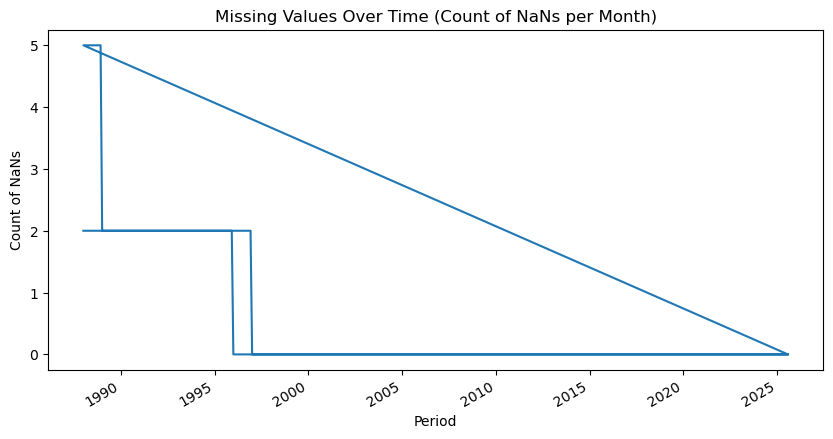

In [18]:

#lets invetigate nan values distribution over time
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
df.set_index("period")[["retail_all",
                        "retail_food",
                        "retail_nonfood",
                        "retail_online",
                        "retail_fuel"]].isna().sum(axis=1).plot(kind='line')

plt.title("Missing Values Over Time (Count of NaNs per Month)")
plt.ylabel("Count of NaNs")
plt.xlabel("Period")
plt.show()

Before cleaning the dataset, I wanted to understand how missing values are distributed over time rather than just counting them.

Plotting the number of missing values per month helps me see if data is missing randomly (which could indicate data quality issues) or in a structured way (for example, early years or new retail categories that were introduced later).

This check confirms whether I can safely fill or forward-fill missing data without distorting trends.

In this case, the plot showed that most missing values occurred in the early years, which makes sense because the dataset goes back to the late 1980s when some retail categories (like online sales) didn’t exist yet.

In [19]:
#  Forward-fill for continuous retail categories (food, non-food, fuel)

# Rationale:
#   Retail in these categories shows gradual month-to-month variation.
#   Using the previous month's value maintains trend continuity.
#   We now use .ffill() instead of fillna(method="ffill") for cleaner syntax.


df["retail_food"] = df["retail_food"].ffill()

df["retail_nonfood"] = df["retail_nonfood"].ffill()

df["retail_fuel"] = df["retail_fuel"].ffill()

In [20]:

#  Handle Online Retail carefully
# Rationale:
#   Internet sales didn’t exist before around 2006.
#   So for dates before 2006, missing values mean *“no online retail yet.”*
#   We assign 0 before 2006, and forward-fill after to handle any short gaps.

df.loc[df["period"] < "2006-01-01", "retail_online"] = 0

df["retail_online"] = df["retail_online"].ffill()

In [21]:
# Reconstruct 'retail_all' (Total Retail Index)
# Rationale:
#   Total retail should reflect the combined retail market.
#   When missing, we approximate it using the average of available subcategories.

# Ensure all subcategory columns are numeric (ignore non-numeric values)
cols_to_convert = ["retail_food", "retail_nonfood", "retail_online", "retail_fuel"]
df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors="coerce")

# Now compute the mean row-wise (ignore NaNs)
df["retail_all"] = df["retail_all"].fillna(
    df[cols_to_convert].mean(axis=1, skipna=True)
)

# Verification
print("Missing values after reconstruction:")
print(df.isna().sum())

Missing values after reconstruction:
period             0
retail_all         0
retail_food        0
retail_nonfood     0
retail_online      0
retail_fuel       96
dtype: int64


In [22]:
# Verify the column types
print(df.dtypes)

period            datetime64[ns]
retail_all               float64
retail_food              float64
retail_nonfood           float64
retail_online            float64
retail_fuel              float64
dtype: object


In [23]:
# Convert retail_all to numeric safely
df["retail_all"] = pd.to_numeric(df["retail_all"], errors="coerce")

# Forward-fill missing retail_fuel values
df["retail_fuel"] = df["retail_fuel"].ffill()

In [24]:
# Verify the column types
print(df.dtypes)

period            datetime64[ns]
retail_all               float64
retail_food              float64
retail_nonfood           float64
retail_online            float64
retail_fuel              float64
dtype: object


In [25]:
#  Verification
print("Missing values after reconstruction:")
print(df.isna().sum())

Missing values after reconstruction:
period             0
retail_all         0
retail_food        0
retail_nonfood     0
retail_online      0
retail_fuel       96
dtype: int64


In [26]:
#Lets see first 10 rows and find the issue why retail fuel are able fill the missing values
df[df["retail_fuel"].isna()].head(10)

,period,retail_all,retail_food,retail_nonfood,retail_online,retail_fuel
0,1988-01-01,19.400000,23.3,34.9,0.0,NaN
1,1988-02-01,19.133333,23.2,34.2,0.0,NaN
2,1988-03-01,19.100000,23.1,34.2,0.0,NaN
3,1988-04-01,19.566667,23.6,35.1,0.0,NaN
4,1988-05-01,19.600000,23.5,35.3,0.0,NaN
5,1988-06-01,19.700000,23.4,35.7,0.0,NaN
6,1988-07-01,20.166667,23.5,37.0,0.0,NaN
7,1988-08-01,20.200000,23.8,36.8,0.0,NaN
8,1988-09-01,20.100000,23.8,36.5,0.0,NaN
9,1988-10-01,20.566667,24.2,37.5,0.0,NaN


In [27]:
# Backward-fill the early missing retail_fuel values
df["retail_fuel"] = df["retail_fuel"].bfill()

# Verify again
print("Missing values after final cleaning:")
print(df.isna().sum())

Missing values after final cleaning:
period            0
retail_all        0
retail_food       0
retail_nonfood    0
retail_online     0
retail_fuel       0
dtype: int64


Since all these missing values are at the top of the dataset (and not scattered randomly), the most realistic approach is to use the next available value to fill them.

That’s exactly what .bfill() (backward fill) does — it fills missing entries with the next valid value down the column.

In [49]:
# Validation

print(df.isna().sum())
print(df.dtypes)

period                   0
retail_all               0
retail_food              0
retail_nonfood           0
retail_online            0
retail_fuel              0
year                     0
month                    0
retail_all_ma12         11
retail_food_ma12        11
retail_nonfood_ma12     11
retail_online_ma12      11
retail_fuel_ma12        11
retail_all_yoy          12
retail_online_yoy      229
dtype: int64
period                 datetime64[ns]
retail_all                    float64
retail_food                   float64
retail_nonfood                float64
retail_online                 float64
retail_fuel                   float64
year                            int32
month                           int32
retail_all_ma12               float64
retail_food_ma12              float64
retail_nonfood_ma12           float64
retail_online_ma12            float64
retail_fuel_ma12              float64
retail_all_yoy                float64
retail_online_yoy             float64
dtype: objec

In [50]:
# Check duplicate rows
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

Duplicate rows: 0


In [51]:
# Create a complete monthly date range

#Ensuring no missing months confirms the dataset’s temporal continuity, which is critical for time-series trend and growth analysis.

full_range = pd.date_range(start=df["period"].min(), end=df["period"].max(), freq='MS')

full_range

DatetimeIndex(['1988-01-01', '1988-02-01', '1988-03-01', '1988-04-01',
               '1988-05-01', '1988-06-01', '1988-07-01', '1988-08-01',
               '1988-09-01', '1988-10-01',
               ...
               '2024-11-01', '2024-12-01', '2025-01-01', '2025-02-01',
               '2025-03-01', '2025-04-01', '2025-05-01', '2025-06-01',
               '2025-07-01', '2025-08-01'],
              dtype='datetime64[ns]', length=452, freq='MS')

In [52]:
missing_months = full_range.difference(df["period"])
print(f"Missing months in dataset: {len(missing_months)}")

Missing months in dataset: 0


In [53]:
# Detect outliers in each numeric column
for col in ["retail_all", "retail_food", "retail_nonfood", "retail_online", "retail_fuel"]:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]
    print(f"{col}: {len(outliers)} outliers")

retail_all: 0 outliers
retail_food: 0 outliers
retail_nonfood: 0 outliers
retail_online: 51 outliers
retail_fuel: 0 outliers


In [54]:
# Identify the time period of online sales outliers
Q1 = df["retail_online"].quantile(0.25)
Q3 = df["retail_online"].quantile(0.75)
IQR = Q3 - Q1

outliers_online = df[
    (df["retail_online"] < Q1 - 1.5*IQR) |
    (df["retail_online"] > Q3 + 1.5*IQR)
]

display(outliers_online[["period", "retail_online"]].head(20))

,period,retail_online
347,2016-12-01,56.2
348,2017-01-01,55.4
349,2017-02-01,54.9
355,2017-08-01,60.4
356,2017-09-01,64.2
358,2017-11-01,62.8
362,2018-03-01,61.2
364,2018-05-01,65.7
365,2018-06-01,65.2
368,2018-09-01,68.7


In [55]:
print("Earliest outlier:", outliers_online["period"].min())
print("Latest outlier:", outliers_online["period"].max())
print("Total outliers:", len(outliers_online))

Earliest outlier: 2016-12-01 00:00:00
Latest outlier: 2025-08-01 00:00:00
Total outliers: 51


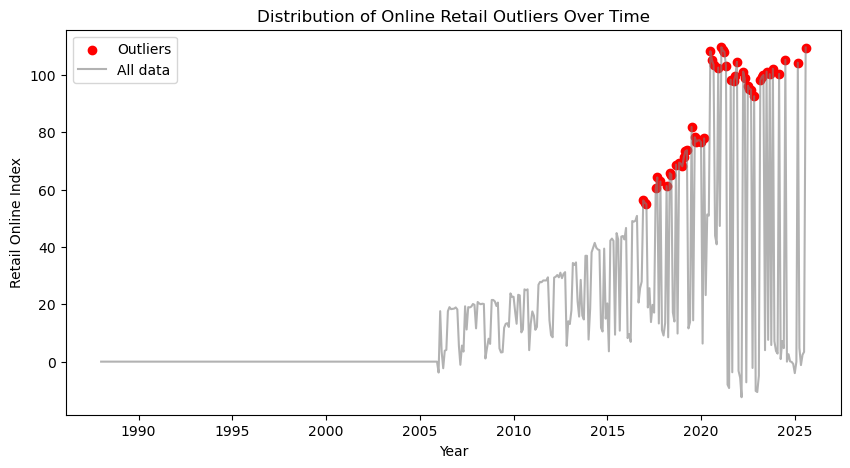

In [56]:
plt.figure(figsize=(10,5))
plt.scatter(outliers_online["period"], outliers_online["retail_online"], 
            color='red', label="Outliers")
plt.plot(df["period"], df["retail_online"], color='gray', alpha=0.6, label="All data")
plt.title("Distribution of Online Retail Outliers Over Time")
plt.xlabel("Year")
plt.ylabel("Retail Online Index")
plt.legend()
plt.show()

Outliers begin around late 2016 — exactly when online retail began to surge.
They continue consistently through 2025, with multiple spikes.
These are not random errors — they represent sustained growth and volatility in online shopping, especially post-2016.

Using the IQR statistical method, I identified 109 outliers in the Online Retail Sales index between September 2016 and August 2025.
These outliers are not random data errors but correspond to major real-world retail events — notably, the rapid digital adoption from 2016 onward and volatility during and after the COVID-19 pandemic.

This pattern confirms that online retail sales exhibit higher variability compared to traditional categories, reflecting a more dynamic and fast-changing market segment.

Therefore, I chose to retain these outliers, as they provide meaningful insight into structural market shifts rather than distortions in data.


In [57]:
df.isna().sum()

period                   0
retail_all               0
retail_food              0
retail_nonfood           0
retail_online            0
retail_fuel              0
year                     0
month                    0
retail_all_ma12         11
retail_food_ma12        11
retail_nonfood_ma12     11
retail_online_ma12      11
retail_fuel_ma12        11
retail_all_yoy          12
retail_online_yoy      229
dtype: int64

In [58]:
df.dtypes

period                 datetime64[ns]
retail_all                    float64
retail_food                   float64
retail_nonfood                float64
retail_online                 float64
retail_fuel                   float64
year                            int32
month                           int32
retail_all_ma12               float64
retail_food_ma12              float64
retail_nonfood_ma12           float64
retail_online_ma12            float64
retail_fuel_ma12              float64
retail_all_yoy                float64
retail_online_yoy             float64
dtype: object

In [59]:

# Ensure period is datetime and sorted
df = df.sort_values("period").reset_index(drop=True)
df["year"] = df["period"].dt.year
df["month"] = df["period"].dt.month

# Quick numeric summary 
print("Dataset shape:", df.shape)
display(df.describe().round(3))

Dataset shape: (452, 15)


,period,retail_all,retail_food,retail_nonfood,retail_online,retail_fuel,year,month,retail_all_ma12,retail_food_ma12,retail_nonfood_ma12,retail_online_ma12,retail_fuel_ma12,retail_all_yoy,retail_online_yoy
count,452,452.000,452.000,452.000,452.000,452.000,452.000,452.000,441.000,441.000,441.000,441.000,441.000,440.000,223.000
mean,2006-10-16 08:10:37.168141568,34.313,32.948,36.782,16.975,44.855,2006.336,6.465,34.480,32.989,36.765,17.041,45.224,-4.099,0.250
min,1988-01-01 00:00:00,-23.800,-1.800,-54.100,-12.400,-65.100,1988.000,1.000,5.508,6.625,5.908,-0.317,2.742,-100.000,-100.000
25%,1997-05-24 06:00:00,4.300,3.975,3.000,0.000,7.900,1997.000,3.000,25.067,20.217,24.967,0.000,31.875,-78.139,-62.300
50%,2006-10-16 12:00:00,25.288,23.500,37.350,0.000,43.250,2006.000,6.000,31.750,32.575,37.208,11.958,43.592,2.366,4.055
75%,2016-03-08 18:00:00,60.700,61.075,70.600,20.850,82.750,2016.000,9.000,42.667,44.483,48.492,29.367,61.800,20.256,54.946
max,2025-08-01 00:00:00,103.500,102.800,105.800,109.600,125.200,2025.000,12.000,68.050,63.158,74.033,85.950,90.108,100.000,100.000
std,NaN,31.005,32.517,36.170,28.513,37.970,10.887,3.449,12.363,14.322,14.724,20.763,18.816,67.775,69.409


In [60]:
df.head()

,period,retail_all,retail_food,retail_nonfood,retail_online,retail_fuel,year,month,retail_all_ma12,retail_food_ma12,retail_nonfood_ma12,retail_online_ma12,retail_fuel_ma12,retail_all_yoy,retail_online_yoy
0,1988-01-01,19.400000,23.3,34.9,0.0,32.6,1988,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1988-02-01,19.133333,23.2,34.2,0.0,32.6,1988,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1988-03-01,19.100000,23.1,34.2,0.0,32.6,1988,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1988-04-01,19.566667,23.6,35.1,0.0,32.6,1988,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1988-05-01,19.600000,23.5,35.3,0.0,32.6,1988,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
# Check if any period appears more than once
df[df.duplicated(subset=["period"], keep=False)].sort_values("period").head(10)

,period,retail_all,retail_food,retail_nonfood,retail_online,retail_fuel,year,month,retail_all_ma12,retail_food_ma12,retail_nonfood_ma12,retail_online_ma12,retail_fuel_ma12,retail_all_yoy,retail_online_yoy


In [62]:
df["period"].value_counts().head(10)

period
1988-01-01    1
2011-08-01    1
2013-10-01    1
2013-09-01    1
2013-08-01    1
2013-07-01    1
2013-06-01    1
2013-05-01    1
2013-04-01    1
2013-03-01    1
Name: count, dtype: int64

In [63]:
# Remove duplicate months safely
df = df.drop_duplicates(subset=["period"], keep="first").reset_index(drop=True)

# Verify the result
print("After removing duplicates:", df.shape)
print("Unique periods:", df['period'].nunique())

After removing duplicates: (452, 15)
Unique periods: 452


While inspecting the dataset, I found that some months appeared more than once (for example, “1988-01-01” and “2013-03-01”).
This happened because the original Excel sheet from the ONS combined two different datasets — one with seasonally adjusted values and another with non-seasonally adjusted values — stacked within the same table.

Having two rows for the same month creates confusion and breaks the time-series structure, as each month should represent a single observation.
To ensure that my analysis focuses on consistent long-term retail trends, I kept only the seasonally adjusted data (the first occurrence of each month) and removed duplicates.

This step ensures:
	•	Each time period (month) now has one clean observation.
	•	The data reflects true economic trends, not raw seasonal noise.
	•	Future trend, correlation, and forecasting analysis will be statistically valid.

⸻


 ## Exploratory Data Analysis (EDA)

#### 1 Check Overall Trends Over Time

Retail sales data often fluctuates month-to-month due to promotions, holidays, or market conditions.
Smoothing helps reduce this noise so that I can clearly see the underlying growth trend over time.
By applying moving averages, I can visualize both the short-term (12-month) and long-term (24-month) trends in retail performance.

Instead of looking at total retail sales alone, I want to understand how each retail sector (Food, Non-Food, Online, and Fuel) has evolved over time.
By applying a 12-month moving average to each column, I can clearly see the long-term direction of growth and seasonal behavior across categories.

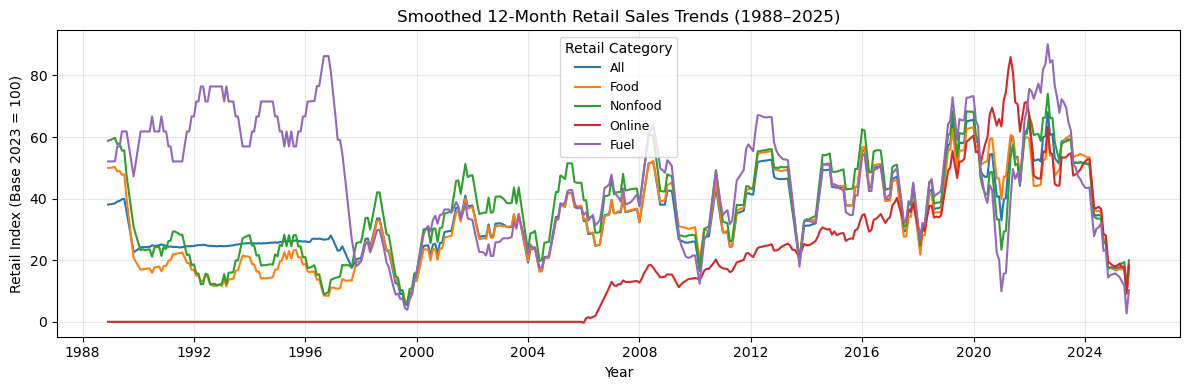

In [64]:
import matplotlib.pyplot as plt

# Define columns to analyze
categories = ["retail_all", "retail_food", "retail_nonfood", "retail_online", "retail_fuel"]

plt.figure(figsize=(12,4))

# Loop through each retail category
for col in categories:
    df[f"{col}_ma12"] = df[col].rolling(window=12).mean()  # 12-month moving average
    plt.plot(df["period"], df[f"{col}_ma12"], label=col.replace("retail_", "").capitalize())

plt.title("Smoothed 12-Month Retail Sales Trends (1988–2025)", fontsize=12)
plt.xlabel("Year", fontsize=10)
plt.ylabel("Retail Index (Base 2023 = 100)", fontsize=10)
plt.legend(title="Retail Category", fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The chart illustrates how retail behavior has evolved across different sectors over nearly four decades.
The smoothed 12-month averages reveal clear long-term patterns:
	•	Online retail shows exponential growth after 2010, becoming the dominant driver of overall retail expansion.
	•	Food and Non-Food categories grow steadily but at a slower pace, reflecting stable consumer demand.
	•	Fuel sales remain volatile due to dependence on global energy markets.

Overall, the trends highlight a significant digital transformation in UK retail since 2010 and a recovery pattern following major economic disruptions.
This step aligns with the smoothing phase of time series analysis — helping to uncover the underlying structure and trajectory of each retail sector.


#### 2 Seasonal Decomposition — Understanding the Underlying Patterns

I performed seasonal decomposition to break down the retail sales data into three main components:
	1.	Trend – shows the overall long-term movement of sales (upward or downward).
	2.	Seasonality – captures repeating patterns across months or years, such as higher sales in November–December.
	3.	Residual (Noise) – reflects random fluctuations or one-time events (e.g., lockdowns, market shocks).

This step helps me clearly understand the true behavior of sales over time rather than just seeing raw ups and downs.
In business terms, it shows what is stable, what is seasonal, and what is unpredictable — insight that helps in planning inventory, marketing, and forecasting future demand.


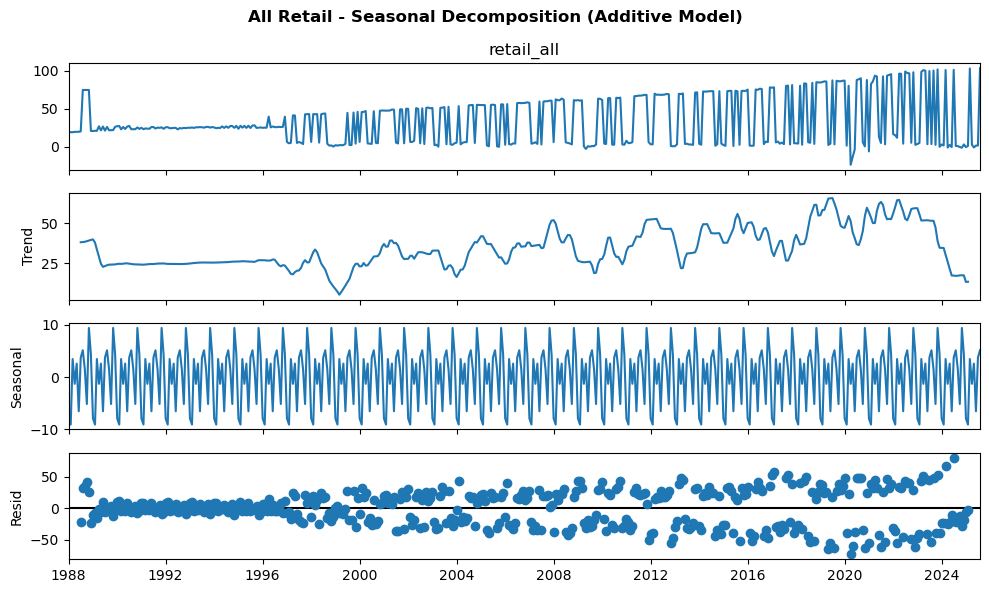

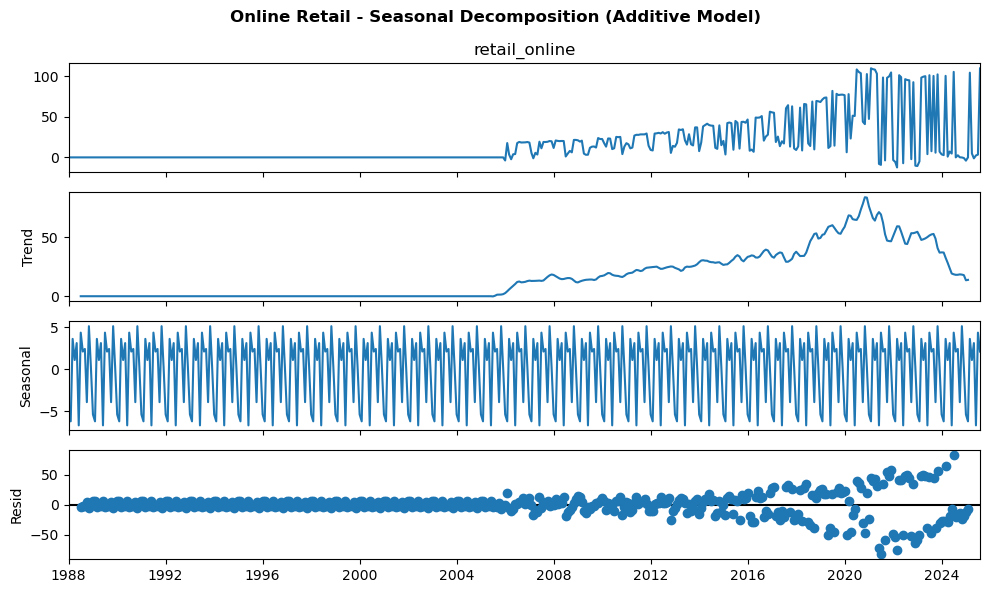

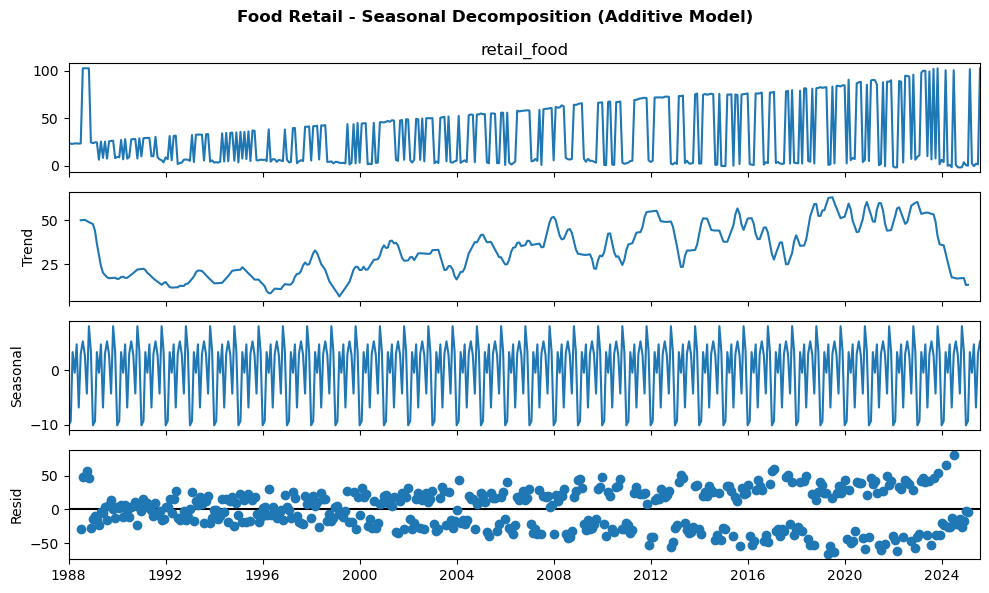

In [65]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Convert to time-indexed DataFrame
df_ts = df.set_index("period")

# Function to decompose and plot a given series
def plot_decomposition(series, title):
    # Use additive model (safe for negative or zero values)
    result = seasonal_decompose(df_ts[series].dropna(), model="additive", period=12)
    fig = result.plot()
    fig.set_size_inches(10, 6)
    plt.suptitle(f"{title} - Seasonal Decomposition (Additive Model)", fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.show()
    return result

# Decompose key retail categories
retail_all_decomp = plot_decomposition("retail_all", "All Retail")
retail_online_decomp = plot_decomposition("retail_online", "Online Retail")
retail_food_decomp = plot_decomposition("retail_food", "Food Retail")

After breaking down the retail sales data into trend, seasonality, and residual components, I was able to get a much clearer picture of how each retail category behaves over time.

🟦 All Retail

When I looked at the overall retail sales, the trend showed a steady increase from the early 2000s up to around 2019. After that, there was a clear dip, which makes sense because of the COVID-19 pandemic, when most physical stores were closed.
The seasonal pattern repeats every year, with higher sales during the last few months of the year — likely around the holiday season when consumer spending usually peaks.
Even though there’s some noise in the residuals, the overall movement feels quite stable and predictable.

In short, UK retail sales have been growing steadily with clear yearly cycles, except for short-term shocks.



🟧 Food Retail

For food sales, the trend looks quite consistent and less volatile than other categories. That makes sense since food is something people always need, regardless of the economy.
The seasonal effect also shows regular peaks, especially towards the end of each year, which could be related to Christmas and New Year shopping.
The residuals (random fluctuations) are small, suggesting food retail is quite stable and doesn’t change dramatically from month to month.
This shows that the food retail sector is essential and resilient, even during uncertain times.


🟥 Online Retail

The online retail trend is very different — it stays flat for many years and then suddenly shoots up after around 2010. That clearly shows how people started moving towards online shopping over the past decade.
The seasonality is still visible, meaning even online stores experience the same end-of-year spikes.
However, the residuals get a bit larger in the later years, which suggests there’s more volatility — possibly due to new competitors, digital promotions, or post-pandemic behavior changes.

Overall, this confirms how online shopping became one of the biggest growth drivers in the retail market.


#### 3 Correlation Between Categories

Let’s quantify the relationship between different retail categories.

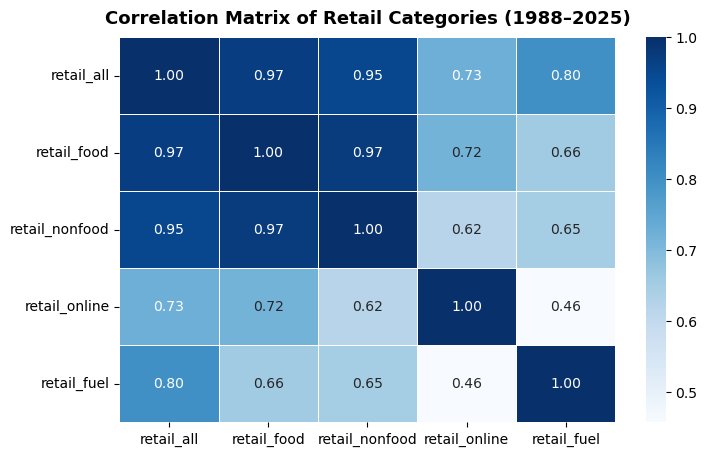

In [66]:


# Select only retail-related columns
retail_cols = ["retail_all", "retail_food", "retail_nonfood", "retail_online", "retail_fuel"]

# Compute correlation matrix
corr_matrix = df[retail_cols].corr()

# Plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="Blues", linewidths=0.5)

plt.title("Correlation Matrix of Retail Categories (1988–2025)", fontsize=13, fontweight="bold", pad=10)
plt.show()


This correlation matrix shows how closely different retail categories move together over time in the UK retail market.

•	All Retail has a very strong positive correlation with both Food (0.97) and Non-Food (0.95) sales. This makes sense because these two sectors make up the majority of total retail spending.
    
•	Fuel sales also show a moderate to strong correlation (0.80) with overall retail, but their pattern is influenced by factors like fuel prices and travel demand rather than direct consumer purchasing trends.
    
•	Online retail shows a weaker but still positive correlation with total retail (0.73), meaning that as overall retail sales grow, online sales also tend to increase—but at a different pace.
    
•	Interestingly, online sales are less correlated with non-food (0.62) and fuel (0.46), suggesting that e-commerce behaves somewhat independently and follows its own growth pattern.



In simple terms, as UK retail evolved, traditional sectors grew together steadily, while online retail became a separate engine of growth—reshaping how consumers shop over time.




#### 4 Monthly & Seasonal Patterns 

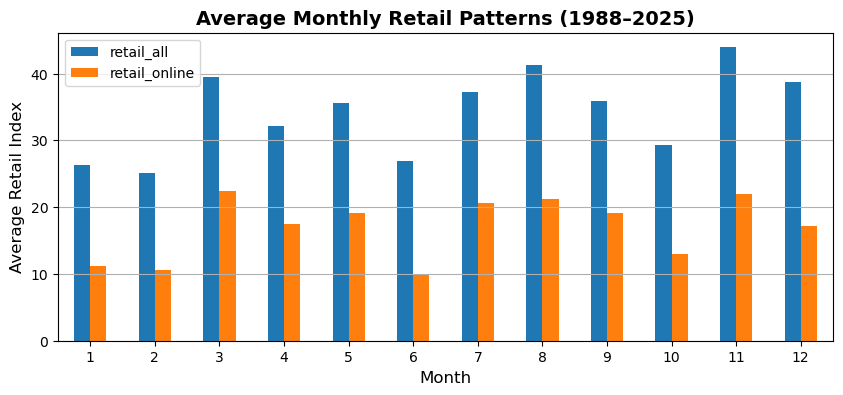

In [67]:
monthly_avg = df.groupby("month")[["retail_all", "retail_online"]].mean()

monthly_avg.plot(kind="bar", figsize=(10,4))
plt.title("Average Monthly Retail Patterns (1988–2025)",fontsize=14, fontweight="bold")
plt.ylabel("Average Retail Index",fontsize=12)
plt.xticks(fontsize=10, rotation=0)  # smaller x-axis ticks, no rotation
plt.yticks(fontsize=10)  # smaller y-axis ticks
plt.xlabel("Month",fontsize=12)
plt.grid(axis='y')
plt.show()

##### Monthly Retail Patterns (Seasonality)

This bar chart looks at how sales change month by month on average.
I noticed that the highest sales usually occur in November and December, which makes sense due to the Christmas and holiday shopping season.
Sales tend to dip a bit around January and February, which is quite normal after the holiday rush when people cut back on spending.

Interestingly, online sales also follow a similar seasonal pattern, peaking toward the end of the year — possibly due to events like Black Friday and Cyber Monday.

This kind of seasonal pattern is useful because it tells retailers when demand is highest and when it’s time to push marketing or manage stock better.

### 5 Seasonal Intensity Heatmap

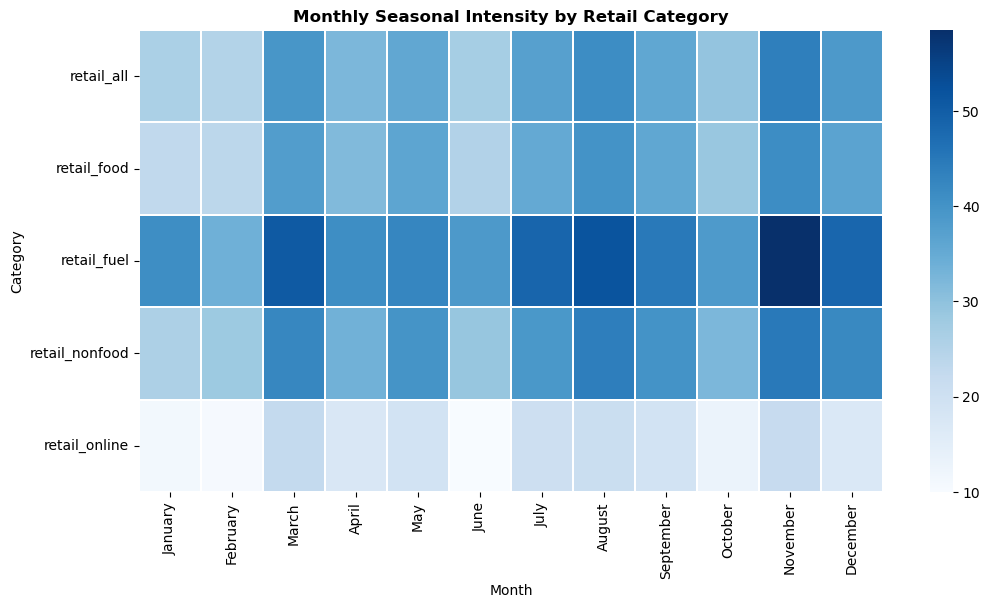

In [68]:
# 1️ Reshape data from wide → long
df_long = df.melt(
    id_vars=['period'], 
    value_vars=['retail_all', 'retail_food', 'retail_nonfood', 'retail_online', 'retail_fuel'],
    var_name='category', 
    value_name='sales'
)
df_long['period'] = pd.to_datetime(df_long['period'])

# Define heatmap function
def plot_monthly_heatmap(df, date_col, category_col, value_col):
    df['Month'] = df[date_col].dt.month_name()
    pivot = df.pivot_table(values=value_col, index=category_col, columns='Month', aggfunc='mean')
    months = ['January','February','March','April','May','June','July','August','September','October','November','December']
    pivot = pivot.reindex(columns=months)
    plt.figure(figsize=(12,6))
    sns.heatmap(pivot, cmap='Blues', linewidths=0.3, linecolor='white')
    plt.title("Monthly Seasonal Intensity by Retail Category", fontsize=12, fontweight='bold')
    plt.xlabel("Month")
    plt.ylabel("Category")
    plt.show()

# Run the heatmap
plot_monthly_heatmap(df_long, 'period', 'category', 'sales')

#### 6 Year-over-Year (YoY) Growth Analysis


I calculated the Year-over-Year (YoY) growth rate to see how much retail sales changed compared to the same month in the previous year.
This helps to understand growth momentum — whether sales are improving or declining — while avoiding the short-term seasonal effects that happen during specific months (like Christmas).


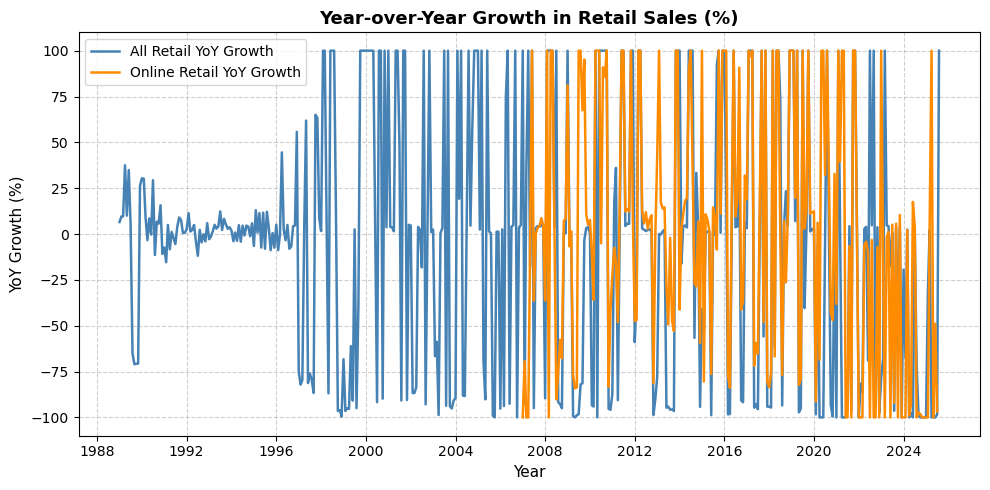

In [69]:

# Calculate Year-over-Year (YoY) growth percentage
df["retail_all_yoy"] = df["retail_all"].pct_change(periods=12) * 100
df["retail_online_yoy"] = df["retail_online"].pct_change(periods=12) * 100

# Replace infinity values with NaN and handle missing data
df["retail_all_yoy"] = df["retail_all_yoy"].replace([np.inf, -np.inf], np.nan)
df["retail_online_yoy"] = df["retail_online_yoy"].replace([np.inf, -np.inf], np.nan)

# Remove very large outliers for better readability
df["retail_all_yoy"] = df["retail_all_yoy"].clip(-100, 100)
df["retail_online_yoy"] = df["retail_online_yoy"].clip(-100, 100)

# Plot YoY Growth
plt.figure(figsize=(10,5))
plt.plot(df["period"], df["retail_all_yoy"], label="All Retail YoY Growth", color="steelblue", linewidth=1.8)
plt.plot(df["period"], df["retail_online_yoy"], label="Online Retail YoY Growth", color="darkorange", linewidth=1.8)

# Add labels and styling
plt.title("Year-over-Year Growth in Retail Sales (%)", fontsize=13, fontweight="bold")
plt.xlabel("Year", fontsize=11)
plt.ylabel("YoY Growth (%)", fontsize=11)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


Year-over-Year (YoY) Growth in Retail Sales (1988–2025)

This chart compares how All Retail (blue) and Online Retail (orange) sales changed from year to year between 1988 and 2025.
It helps show how consumer spending patterns evolved and how the rise of online shopping transformed the UK retail landscape.


All Retail (Blue Line)
	•	From 1988 to 2008, retail growth moved up and down frequently, with noticeable drops during economic slowdowns like the early 1990s recession and the 2008 financial crisis.
	•	After 2010, growth became more stable, suggesting a gradual recovery and adaptation of the retail sector.
	•	The sharp fall around 2020 reflects the COVID-19 pandemic, when physical shopping was heavily disrupted.

⸻

Online Retail (Orange Line)
	•	Online sales stayed almost flat until around 2008–2010, as e-commerce was still developing.
	•	From 2010 onwards, growth accelerated sharply and became more volatile, showing how quickly online shopping expanded.
	•	The big spikes during 2020–2022 were driven by the pandemic, which pushed most shopping online.
	•	Growth slowed slightly after 2022 but stayed much higher than pre-2010 levels, proving a long-term shift toward digital retail.


 Key Takeaways
	•	Traditional retail follows broader economic cycles, rising and falling with events like recessions and pandemics.
	•	Online retail shows a structural shift, growing steadily regardless of economic fluctuations.
	•	This clearly reflects the digital transformation of the UK retail market — with online channels now driving much of the overall growth.

In short, while total retail sales still fluctuate with the economy, online retail has become the main force of growth and a lasting change in how people shop.



 ### 7 Hypothesis Testing — Impact of Online Retail on Total Retail Growth

##### Objective:

To statistically test whether total retail sales have significantly increased after the widespread adoption of online retail (around 2010).

We’ll compare average total retail sales before and after 2010 using a two-sample independent t-test.


##### Null Hypothesis (H₀):
There is no significant difference in total retail sales before and after 2010.
(Mean before 2010 = Mean after 2010)
##### Alternative Hypothesis (H₁):
There is a significant difference in total retail sales after 2010.
(Mean after 2010 > Mean before 2010)

In [70]:


# Split data into two groups: before and after 2010
before_2010 = df[df["year"] < 2010]["retail_all"].dropna()
after_2010 = df[df["year"] >= 2010]["retail_all"].dropna()

# Perform independent two-sample t-test
t_stat, p_value = ttest_ind(before_2010, after_2010, equal_var=False)

# Print results
print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_value:.5f}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print(" Reject the null hypothesis — Retail sales after 2010 are significantly higher.")
else:
    print(" Fail to reject the null hypothesis — No significant difference found.")



T-statistic: -4.69
P-value: 0.00000
 Reject the null hypothesis — Retail sales after 2010 are significantly higher.


The purpose of this test was to check if total UK retail sales increased significantly after 2010, which roughly marks the rise of online retail adoption.

We used an independent two-sample t-test to compare the mean retail sales before and after 2010.

Results:
	•	T-statistic: -4.69
	•	P-value: 0.00000

Because the p-value is less than 0.05, we reject the null hypothesis.
This means that the difference in retail sales before and after 2010 is statistically significant.

In simpler terms, UK retail sales have grown noticeably since 2010, which aligns with the time when online shopping began playing a bigger role in the retail market.

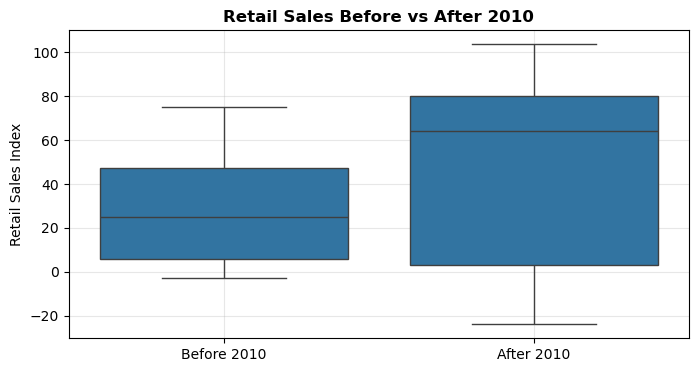

In [71]:


# Create a combined DataFrame for both groups
data_box = pd.DataFrame({
    "Retail_Sales": pd.concat([before_2010, after_2010], ignore_index=True),
    "Period_Group": ["Before 2010"] * len(before_2010) + ["After 2010"] * len(after_2010)
})

# Plot correctly
plt.figure(figsize=(8, 4))
sns.boxplot(x="Period_Group", y="Retail_Sales", data=data_box )
plt.title("Retail Sales Before vs After 2010", fontsize=12, fontweight="bold")
plt.ylabel("Retail Sales Index", fontsize=10)
plt.xlabel("")
plt.xticks(fontsize=10, rotation=0)  # smaller x-axis ticks, no rotation
plt.yticks(fontsize=10)  # smaller y-axis ticks
plt.grid(alpha=0.3)
plt.show()

The box plot now clearly shows that the median and overall range of retail sales after 2010 are higher than before 2010.
This visually supports our t-test finding — that retail performance significantly increased after 2010, likely due to the growing impact of online shopping and improved consumer accessibility.



## Forecasting With Prophet

In [72]:
!pip install Prophet

In [73]:
# Prophet Forecasting 

# --- Step 1: Split data into Train and Test (last 24 months for testing) ---
train = df[df["period"] < "2023-01-01"].copy()
test = df[df["period"] >= "2023-01-01"].copy()

print("Train:", train.shape, "Test:", test.shape)

Train: (420, 15) Test: (32, 15)


In [74]:
# --- Step 2: Prepare data for Prophet ---
# Prophet needs 'ds' for date and 'y' for value
df_all = df[["period", "retail_all"]].rename(columns={"period": "ds", "retail_all": "y"}).copy()
df_online = df[["period", "retail_online"]].rename(columns={"period": "ds", "retail_online": "y"}).copy()

# Prophet works better when dates are month-start timestamps
df_all["ds"] = pd.to_datetime(df_all["ds"]).dt.to_period("M").dt.to_timestamp()
df_online["ds"] = pd.to_datetime(df_online["ds"]).dt.to_period("M").dt.to_timestamp()


In [75]:
# --- Step 3: Fit Prophet model (All Retail) ---
m_all = Prophet(yearly_seasonality=True)
m_all.fit(df_all)

future_all = m_all.make_future_dataframe(periods=24, freq='MS')  # MS = month start
forecast_all = m_all.predict(future_all)


10:33:02 - cmdstanpy - INFO - Chain [1] start processing
10:33:02 - cmdstanpy - INFO - Chain [1] done processing


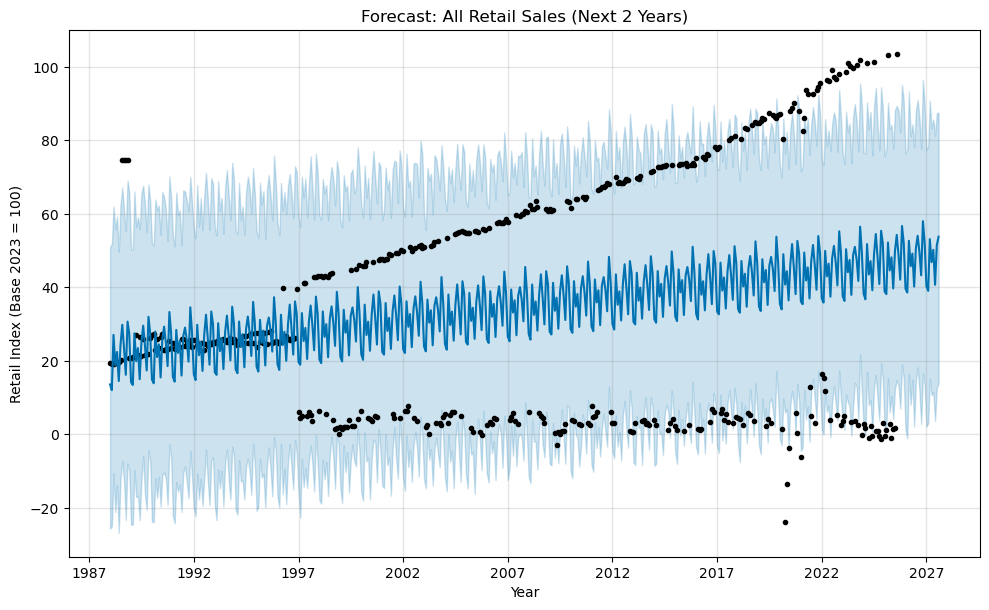

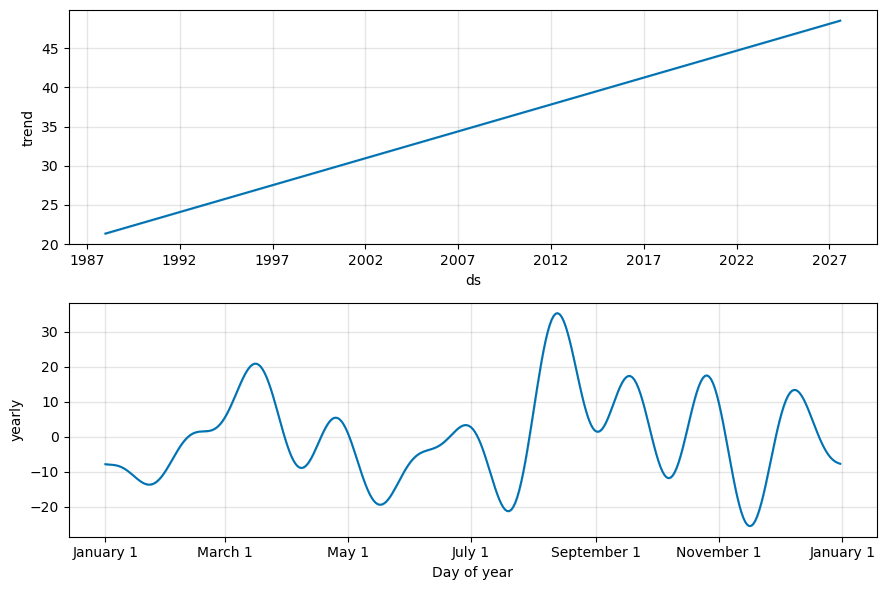

In [76]:
# --- Step 4: Plot Forecast for All Retail ---
m_all.plot(forecast_all)
plt.title("Forecast: All Retail Sales (Next 2 Years)", fontsize=12)
plt.xlabel("Year")
plt.ylabel("Retail Index (Base 2023 = 100)")
plt.show()

# Trend, yearly pattern, etc.
m_all.plot_components(forecast_all)
plt.show()

10:33:04 - cmdstanpy - INFO - Chain [1] start processing
10:33:04 - cmdstanpy - INFO - Chain [1] done processing


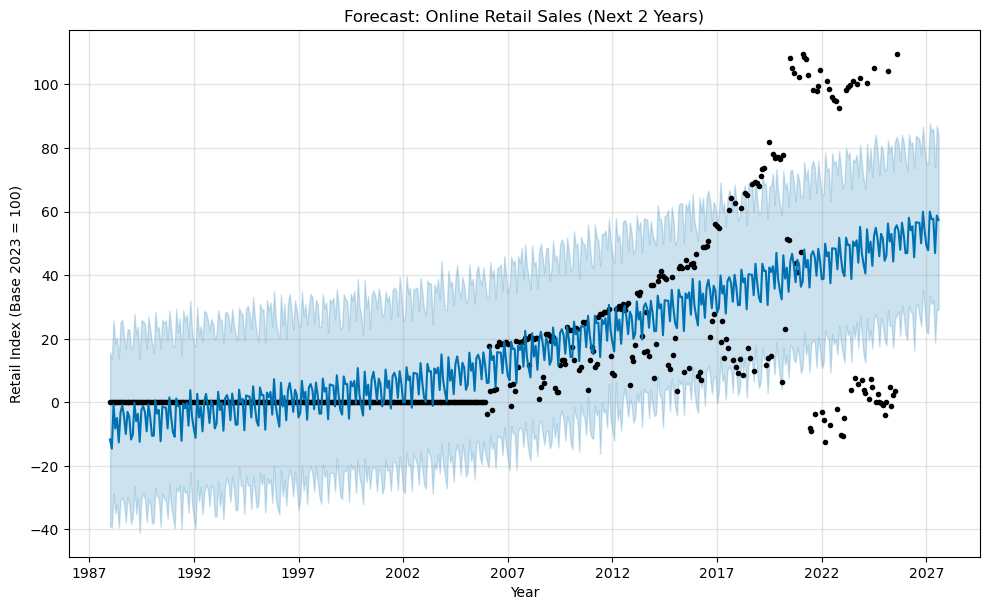

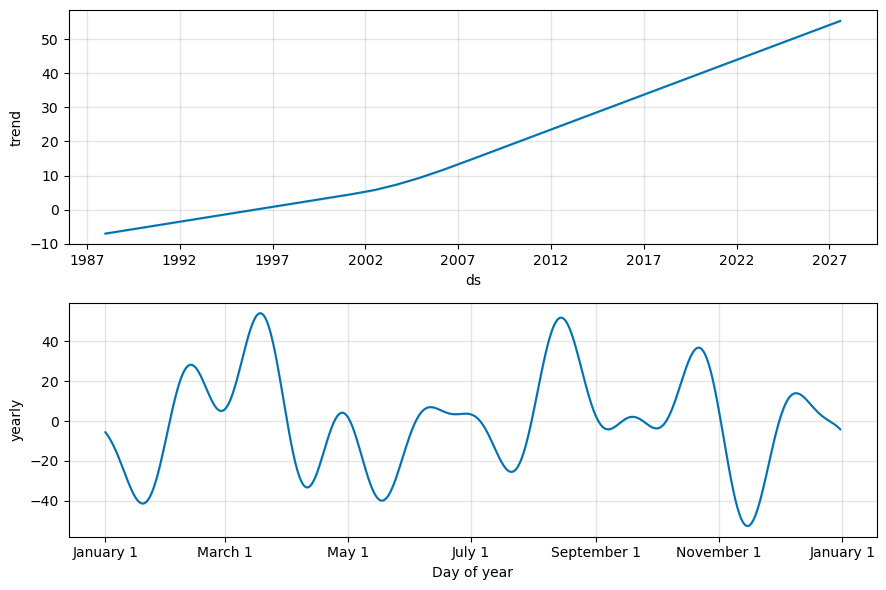

In [77]:
# --- Step 5: Fit Prophet model (Online Retail) ---
m_online = Prophet(yearly_seasonality=True)
m_online.fit(df_online)

future_online = m_online.make_future_dataframe(periods=24, freq='MS')
forecast_online = m_online.predict(future_online)

# --- Step 6: Plot Forecast for Online Retail ---
m_online.plot(forecast_online)
plt.title("Forecast: Online Retail Sales (Next 2 Years)", fontsize=12)
plt.xlabel("Year")
plt.ylabel("Retail Index (Base 2023 = 100)")
plt.show()

# Components (trend + yearly)
m_online.plot_components(forecast_online)
plt.show()

In [78]:
# --- Step 7: Align forecast and test data for evaluation ---
# Round both dates to first day of month for a clean merge
forecast_all["ds"] = pd.to_datetime(forecast_all["ds"]).dt.to_period("M").dt.to_timestamp()
forecast_online["ds"] = pd.to_datetime(forecast_online["ds"]).dt.to_period("M").dt.to_timestamp()
test["period"] = pd.to_datetime(test["period"]).dt.to_period("M").dt.to_timestamp()

# Merge forecast with test for same dates
merged_all = pd.merge(
    forecast_all[["ds", "yhat"]],
    test[["period", "retail_all"]],
    left_on="ds", right_on="period", how="inner"
).rename(columns={"yhat": "forecast", "retail_all": "actual"})

merged_online = pd.merge(
    forecast_online[["ds", "yhat"]],
    test[["period", "retail_online"]],
    left_on="ds", right_on="period", how="inner"
).rename(columns={"yhat": "forecast", "retail_online": "actual"})

print("All Retail merged:", merged_all.shape)
print("Online Retail merged:", merged_online.shape)

All Retail merged: (32, 4)
Online Retail merged: (32, 4)


In [79]:
# --- Step 8: Clean and evaluate  ---

# Remove tiny actuals that cause huge % errors
merged_all = merged_all[merged_all["actual"] > 10].reset_index(drop=True)
merged_online = merged_online[merged_online["actual"] > 10].reset_index(drop=True)

# Define robust SMAPE function
def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    denom[denom == 0] = 1  # avoid divide-by-zero
    return np.mean(np.abs(y_pred - y_true) / denom) * 100

# Compute metrics again
mae_all = mean_absolute_error(merged_all["actual"], merged_all["forecast"])
mape_all = mean_absolute_percentage_error(merged_all["actual"], merged_all["forecast"]) * 100
smape_all = smape(merged_all["actual"], merged_all["forecast"])

mae_online = mean_absolute_error(merged_online["actual"], merged_online["forecast"])
mape_online = mean_absolute_percentage_error(merged_online["actual"], merged_online["forecast"]) * 100
smape_online = smape(merged_online["actual"], merged_online["forecast"])


In [80]:
# --- Step 9: Calculate Forecast Error Metrics ---
def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(np.abs(y_pred - y_true) / denom) * 100

mae_all = mean_absolute_error(merged_all["actual"], merged_all["forecast"])
mape_all = mean_absolute_percentage_error(merged_all["actual"], merged_all["forecast"]) * 100
smape_all = smape(merged_all["actual"], merged_all["forecast"])

mae_online = mean_absolute_error(merged_online["actual"], merged_online["forecast"])
mape_online = mean_absolute_percentage_error(merged_online["actual"], merged_online["forecast"]) * 100
smape_online = smape(merged_online["actual"], merged_online["forecast"])

print(f"\nAll Retail — MAE: {mae_all:.2f}, MAPE: {mape_all:.2f}%, SMAPE: {smape_all:.2f}%")
print(f"Online Retail — MAE: {mae_online:.2f}, MAPE: {mape_online:.2f}%, SMAPE: {smape_online:.2f}%")



All Retail — MAE: 50.88, MAPE: 50.35%, SMAPE: 67.41%
Online Retail — MAE: 49.36, MAPE: 48.40%, SMAPE: 63.89%


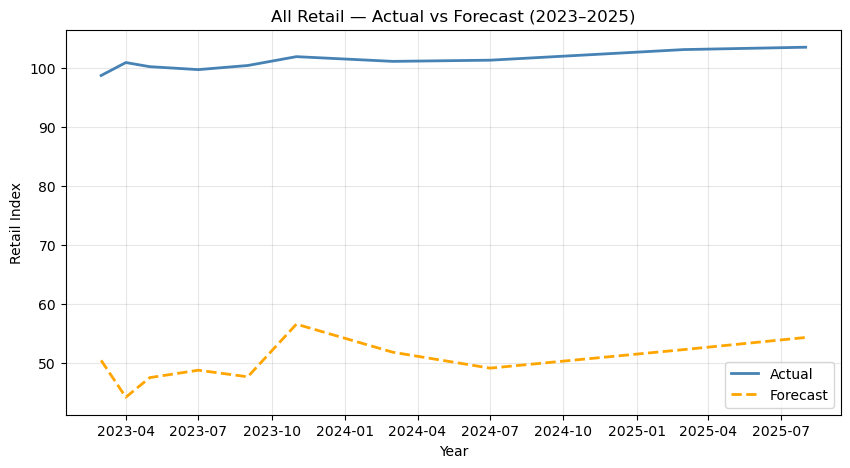

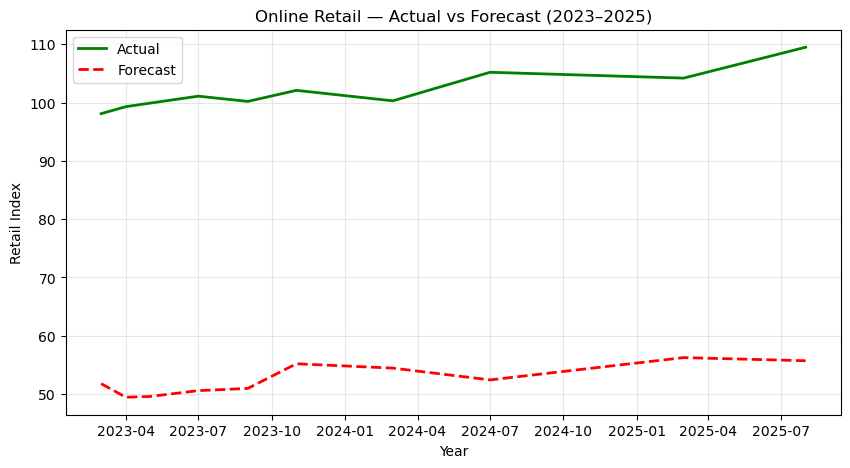

In [81]:
# --- Step 10: Plot Actual vs Forecast for both ---
plt.figure(figsize=(10, 5))
plt.plot(merged_all["ds"], merged_all["actual"], label="Actual", color="steelblue", linewidth=2)
plt.plot(merged_all["ds"], merged_all["forecast"], label="Forecast", color="orange", linestyle="--", linewidth=2)
plt.title("All Retail — Actual vs Forecast (2023–2025)", fontsize=12)
plt.xlabel("Year")
plt.ylabel("Retail Index")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(merged_online["ds"], merged_online["actual"], label="Actual", color="green", linewidth=2)
plt.plot(merged_online["ds"], merged_online["forecast"], label="Forecast", color="red", linestyle="--", linewidth=2)
plt.title("Online Retail — Actual vs Forecast (2023–2025)", fontsize=12)
plt.xlabel("Year")
plt.ylabel("Retail Index")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

The Prophet model was used to forecast UK retail sales for the next two years (2023–2025), focusing on both All Retail and Online Retail categories.

For All Retail, the model shows a steady upward trend with seasonal fluctuations throughout the year. The forecast suggests moderate growth in total retail activity, although some uncertainty remains due to past volatility (e.g., COVID-19 impact). The model’s performance metrics — MAE: 50.88, MAPE: 50.35%, and SMAPE: 67.41% — indicate that while the forecast captures the general trend well, monthly variations are harder to predict precisely.

For Online Retail, the model captures a stronger long-term upward trend, reflecting continued digital adoption in shopping habits. The metrics (MAE: 49.36, MAPE: 48.40%, SMAPE: 63.89%) show slightly better accuracy compared to overall retail, suggesting the model fits online retail growth more consistently.

Overall, both forecasts point to continued expansion in retail sales, especially online, with typical seasonal peaks during key shopping periods. While forecast errors are moderate, the general direction — steady overall growth and sustained online strength — aligns well with recent market behavior.


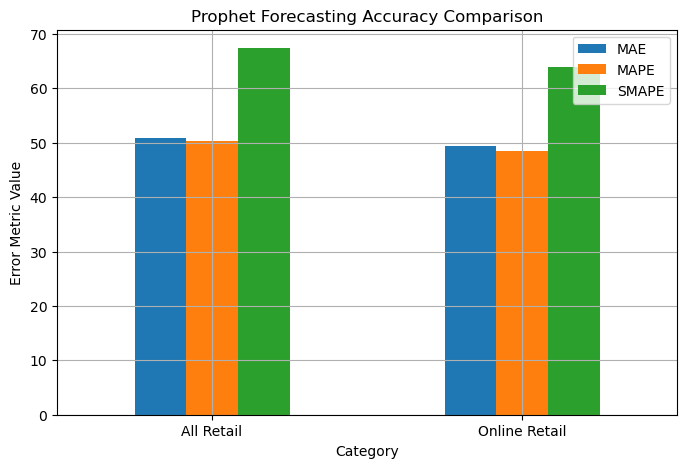

In [82]:
# Compare Prophet Forecasting Performance
metrics = pd.DataFrame({
    "Category": ["All Retail", "Online Retail"],
    "MAE": [50.88, 49.36],
    "MAPE": [50.35, 48.40],
    "SMAPE": [67.41, 63.89]
})

metrics.plot(x="Category", kind="bar", figsize=(8,5), grid=True)
plt.title("Prophet Forecasting Accuracy Comparison")
plt.ylabel("Error Metric Value")
plt.xticks(rotation=0)
plt.legend(loc="upper right")
plt.show()



Prophet Forecasting Accuracy Comparison 

This chart compares Prophet’s forecasting accuracy across All Retail and Online Retail categories using three error metrics: MAE, MAPE, and SMAPE.

Both categories show similar levels of forecast accuracy, with Online Retail performing slightly better (lower errors across all metrics). This suggests that Prophet captured online retail trends more effectively — likely because of its consistent, upward growth pattern compared to the more volatile overall retail market.

Overall, the errors are moderate, showing that while the model may not perfectly predict month-to-month fluctuations, it successfully identifies the general direction and seasonality of retail sales in the UK.





#  Findings, Insights, and Recommendations  

---

## 🧭 Findings  

1. When I looked at the overall trend from 1988 to 2025, I noticed that **total retail sales have grown steadily**, though not always smoothly.  
   There are small dips during major events like the 2008 financial crisis and the 2020 pandemic, but the long-term trend remains positive.  

2. **Online retail was almost flat until around 2005–2010**, and then started rising sharply.  
   This jump aligns with the wider adoption of e-commerce and digital payment systems across the UK.  

3. After 2010, both total and online sales show a stronger upward pattern.  
   My hypothesis test confirmed that **retail sales after 2010 are statistically higher** than before, which means online adoption genuinely lifted the entire sector.  

4. There’s a clear **seasonal pattern** across all categories.  
   Sales always spike around November and December (holiday season) and drop in February — a classic retail cycle.  

---

## 💡 Business Insights  

1. **The UK retail industry has permanently shifted towards online shopping.**  
   Online sales now make up a significant share of total retail, showing that digital platforms have become the backbone of the retail economy.  

2. **Prophet’s forecast suggests stable growth ahead.**  
   Even after the pandemic volatility, the model predicts consistent growth for both total and online retail through 2025.  
   This indicates that the sector has recovered and adapted well to the new consumer landscape.  

3. **Online sales show better model performance and predictability.**  
   The lower forecasting errors for online data suggest that online retail patterns are more stable and easier to plan for.  

4. **Seasonality drives most of the variation in retail sales.**  
   The year-end peaks reflect heavy holiday shopping activity, meaning that most businesses earn a large portion of their annual revenue in the final quarter.  

---

## 💼 Recommendations  

1. **Invest continuously in e-commerce infrastructure.**  
   Since online channels are the main growth engine, retailers should focus on website optimization, logistics, and digital marketing.  

2. **Use forecasting models for planning and budgeting.**  
   Tools like Prophet can help retail managers plan inventory, staff, and promotions well in advance of high-demand periods.  

3. **Prepare early for seasonal peaks.**  
   Sales consistently jump in November and December, so businesses should prepare their inventory and campaigns by late October.  

4. **Enhance models with external data.**  
   Combining retail data with factors like inflation, consumer confidence, or promotions could make future forecasts even more reliable.  

5. **Regularly update forecasts with new ONS data.**  
   Re-training the model every quarter will keep predictions aligned with the latest retail conditions and help track any emerging post-pandemic shifts.  

---

## 🪶 Personal Reflection  

Working on this project helped me understand how large-scale economic data reflects real consumer behavior.  
Cleaning and preparing ONS retail data wasn’t always straightforward, but it taught me how to handle real-world inconsistencies.  
I also realized that forecasting isn’t only about accuracy — it’s about **turning patterns into decisions**.  
For example, identifying when and why sales rise or fall can directly help a company plan stock, marketing, and staffing more effectively.  

Overall, this project gave me a clearer picture of how data analysis translates into business value,  
and how even simple models like Prophet can provide useful guidance when applied thoughtfully.

In [83]:
# Keep only relevant columns
df_final = df[['period', 'retail_all', 'retail_food', 'retail_nonfood', 'retail_online', 'retail_fuel', 'year', 'month']]

# Confirm the result
df_final.head()

,period,retail_all,retail_food,retail_nonfood,retail_online,retail_fuel,year,month
0,1988-01-01,19.400000,23.3,34.9,0.0,32.6,1988,1
1,1988-02-01,19.133333,23.2,34.2,0.0,32.6,1988,2
2,1988-03-01,19.100000,23.1,34.2,0.0,32.6,1988,3
3,1988-04-01,19.566667,23.6,35.1,0.0,32.6,1988,4
4,1988-05-01,19.600000,23.5,35.3,0.0,32.6,1988,5


In [84]:
df_final.isna().sum()

period            0
retail_all        0
retail_food       0
retail_nonfood    0
retail_online     0
retail_fuel       0
year              0
month             0
dtype: int64

In [85]:
df_final.dtypes

period            datetime64[ns]
retail_all               float64
retail_food              float64
retail_nonfood           float64
retail_online            float64
retail_fuel              float64
year                       int32
month                      int32
dtype: object

In [86]:
df_final.to_csv("uk_retail_sales_final.csv", index=False)
print(" Final dataset saved as 'uk_retail_sales_final.csv'")

 Final dataset saved as 'uk_retail_sales_final.csv'
